In [1]:
import squigglepy as sq

from datetime import datetime
from pprint import pprint

from libs import plot_exponential_growth
from model_params import start_task_length, agi_task_length, doubling_time, shift, current_best_date

print("Loaded libraries")

## START task length (displayed in sec) ##
{1: 1.0,
 5: 1.0,
 10: 1.0,
 20: 1.0,
 30: 1.84,
 40: 3.86,
 50: 7.63,
 60: 14.73,
 70: 29.66,
 80: 67.83,
 90: 212.54,
 95: 557.29,
 99: 3189.36}



## AGI task length (displayed in hrs) ##
{1: 40,
 5: 51,
 10: 80,
 20: 138,
 30: 206,
 40: 291,
 50: 402,
 60: 551,
 70: 777,
 80: 1159,
 90: 2008,
 95: 3146,
 99: 7403}



## DOUBLING TIME (displayed in days) ##
{1: 83,
 5: 105,
 10: 119,
 20: 139,
 30: 155,
 40: 171,
 50: 187,
 60: 204,
 70: 225,
 80: 251,
 90: 293,
 95: 333,
 99: 425}



## SHIFT (displayed in days) ##
{1: 0,
 5: 31,
 10: 57,
 20: 88,
 30: 112,
 40: 131,
 50: 150,
 60: 169,
 70: 188,
 80: 211,
 90: 243,
 95: 270,
 99: 320}
Loaded libraries


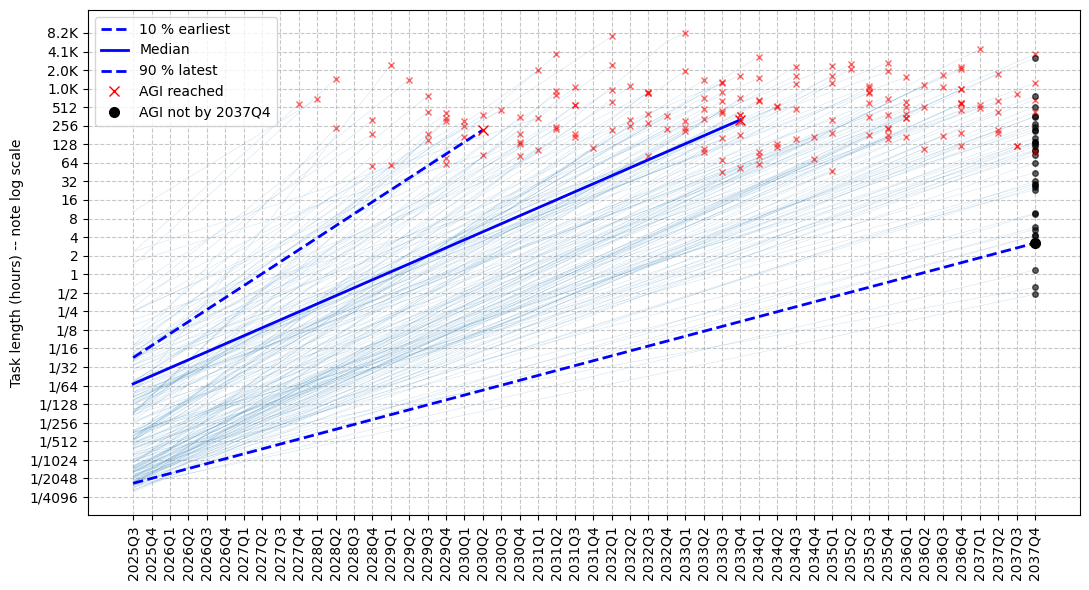

In [2]:
samples = plot_exponential_growth(
    doubling_time_days=doubling_time,
    start_hours=start_task_length,
    start_date=current_best_date,
    agi_task_length=agi_task_length,
    shift=shift,
    n_quarters=49,
    n_samples=100_000,
    n_traces=200,
    max_task_power=13,
    min_y_power=-15,
)

In [3]:
### UNDER CONSTRUCTION

"""
╔══════════════════════════════════════════════════════════╗
║                                                          ║
║                  UNDER CONSTRUCTION                      ║
║                                                          ║
║                      /\                                  ║
║                     /  \                                 ║
║                    / !! \                                ║
║                   /      \                               ║
║                  /   O    \                              ║
║                 /   /|\    \                             ║
║                /   / | \    \                            ║
║               /     _|_      \                           ║
║              /     / |        \                          ║
║             /     /  |         \                         ║
║            /    _/   |__        \                        ║
║           /    /        \        \                       ║
║          /    |          |________\                      ║
║         /     |         /           \                    ║
║        /______|________/─────────────\                   ║
║              Digging...                                  ║
║                                                          ║
║              PARDON OUR DUST                             ║
║                                                          ║
║        This part is currently being built!               ║
║          Please check back soon...                       ║
║                                                          ║
║                                                          ║
╚══════════════════════════════════════════════════════════╝
"""

'\n╔══════════════════════════════════════════════════════════╗\n║                                                          ║\n║                  UNDER CONSTRUCTION                      ║\n║                                                          ║\n║                      /\\                                  ║\n║                     /  \\                                 ║\n║                    / !! \\                                ║\n║                   /      \\                               ║\n║                  /   O    \\                              ║\n║                 /   /|\\    \\                             ║\n║                /   / | \\    \\                            ║\n║               /     _|_      \\                           ║\n║              /     / |        \\                          ║\n║             /     /  |         \\                         ║\n║            /    _/   |__        \\                        ║\n║           /    /        \\        \\                

In [4]:
# -----------
# ACCELERATION: Is the curve actually superexponential or subexponential? Does the doubling time itself change? Set the curve parameter.

print("\n\n")
print("## ACCELERATION")
acceleration = sq.mixture([
        [0.1, 1 + sq.lognorm(0.005, 0.1, credibility=80)],
        [0.8, 1],
        [0.1, 1 - sq.lognorm(0.005, 0.1, credibility=80)],
    ])
pprint(sq.get_percentiles(acceleration @ 100_000, digits=3))




## ACCELERATION
{1: 0.901,
 5: 0.978,
 10: 1.0,
 20: 1.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.022,
 99: 1.098}


In [5]:
from libs import run_model, calculate_doubling_time

def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model, index_date=current_best_date, cores=4)

analyze_agi_arrival(samples)

Generating samples with 4 cores...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3664.52it/s]


Shuffling data...
Waiting for other cores...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1923.99it/s]


...Collected!
{1: 982,
 5: 1448,
 10: 1763,
 20: 2194,
 30: 2559,
 40: 2915,
 50: 3277,
 60: 3680,
 70: 4163,
 80: 4805,
 90: 5844,
 95: 6827,
 99: 9249}

-

{1: '2028 Apr 15',
 5: '2029 Jul 25',
 10: '2030 Jun 05',
 20: '2031 Aug 10',
 30: '2032 Aug 09',
 40: '2033 Jul 31',
 50: '2034 Jul 29',
 60: '2035 Sep 05',
 70: '2036 Dec 31',
 80: '2038 Oct 03',
 90: '2041 Aug 07',
 95: '2044 Apr 16',
 99: '2050 Dec 04'}


NameError: name 'analyze_agi_arrival' is not defined

In [ ]:
from libs import analyze_agi_arrival
analyze_agi_arrival(samples)